In [1]:
import timeit
import matplotlib.pyplot as plt
import pickle
from time import time
import numpy as np

In [2]:
from mnist import MNIST
print("Loading dataset....")
mndata = MNIST('../mnist_dataset')
X_train, y_train = mndata.load_training()
X_train = (mndata.process_images_to_numpy(X_train)/255).astype(np.float32)
X_test, y_test = mndata.load_testing()
X_test = (mndata.process_images_to_numpy(X_test)/255).astype(np.float32)
print("Done.")

Loading dataset....
Done.


In [3]:
X_train=X_train*2 - 1
X_test=X_test*2 - 1
X_train=np.concatenate([X_train,X_test])

In [4]:
from nnet.network import Sequential,layers
from nnet.layers import conv2d,max_pool,flatten,dense,dropout
from nnet import functions
from nnet import optimizers
import numpy as np

Seed: 599
Seed: 241


In [5]:
def generator():
    model=Sequential()
    model.add(dense(128,input_shape=(100),activation=functions.leakyRelu))
    model.add(dense(256,activation=functions.leakyRelu))
    model.add(dense(784,activation=functions.tanh))
    return model
g=generator()

In [6]:
g.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 100)                echo             0
__________________________________________________________________________________________
1 dense(dense)            (None, 128)                leakyRelu        12928
__________________________________________________________________________________________
2 dense(dense)            (None, 256)                leakyRelu        33024
__________________________________________________________________________________________
3 dense(dense)            (None, 784)                tanh             201488
Total Params: 247,440
Trainable Params: 247,440
Non-trainable Params: 0


In [7]:
def discriminator():
    model=Sequential()
    model.add(dense(256,input_shape=(784),activation=functions.leakyRelu))
    model.add(dropout(0.3))
    model.add(dense(128,activation=functions.leakyRelu))
    model.add(dropout(0.2))
    model.add(dense(1,activation=functions.sigmoid))
    return model
d=discriminator()

In [8]:
d.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 784)                echo             0
__________________________________________________________________________________________
1 dense(dense)            (None, 256)                leakyRelu        200960
__________________________________________________________________________________________
2 dropout(dropout)        (None, 256)                echo             0
__________________________________________________________________________________________
3 dense(dense)            (None, 128)                leakyRelu        32896
__________________________________________________________________________________________
4 dropout(dropout)        (None, 128)                echo             0
__________________________________________________________________________________________
5 dense

In [9]:
g.compile(optimizer=optimizers.adam,loss=functions.mean_squared_error,learning_rate=0.001)
d.compile(optimizer=optimizers.adam,loss=functions.cross_entropy_with_logits,learning_rate=0.001)

In [42]:
def run():
    batch_size=64
    dsz=X_train.shape[0]
    # Label real ones as 90% real
    y_dis=np.zeros((2*batch_size,1))
    y_dis[:batch_size]=0.9
    y_gen=np.ones((batch_size,1))
    for _b in range(dsz//batch_size):
        stt=time()
        noise=np.random.uniform(-1,1,(batch_size,100))
        # Generate fake images from noise
        generated_images=g.predict(noise)
        # Get random real images
        real_images=X_train[_b*batch_size:(_b+1)*batch_size]
        X = np.concatenate([real_images,generated_images])
        # Train discriminator
        dout=d.fit(X,y_dis)
        # Treat noised input of generator as real data
        noise=np.random.uniform(-1,1,(batch_size,100))
        # Train generator
        gout=g.forward(noise)
        # do not train discriminator and find delta for generator
        dout,err=d.not_fit(gout,y_gen)
        g.backprop(err,g.lenseq_m1)
        g.optimizer(g.sequence,g.learning_rate,g.beta)
        print("\rProgress: {:.2f} %     Sample time: {:.3f}s    _".format(_b*batch_size*100/dsz,time()-stt),end='')

EPOCH: 1 / 40
Progress: 99.84 %     Sample time: 0.026s    _
Epoch time: 0:33s


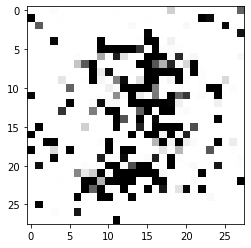

[0.00139467]
EPOCH: 2 / 40
Progress: 99.84 %     Sample time: 0.025s    _
Epoch time: 0:32s


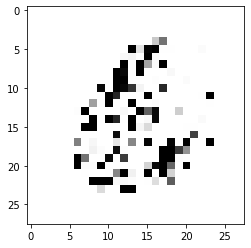

[4.61874123e-07]
EPOCH: 3 / 40
Progress: 99.84 %     Sample time: 0.024s    _
Epoch time: 0:32s


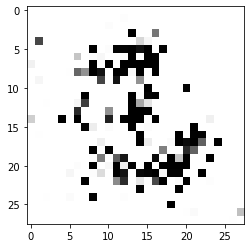

[1.55698164e-05]
EPOCH: 4 / 40
Progress: 99.84 %     Sample time: 0.025s    _
Epoch time: 0:31s


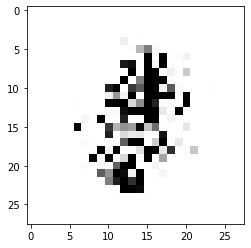

[0.00017527]
EPOCH: 5 / 40
Progress: 99.84 %     Sample time: 0.025s    _
Epoch time: 0:35s


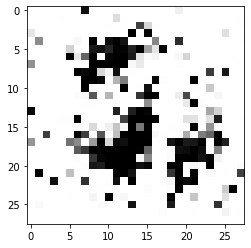

[2.8429699e-06]
EPOCH: 6 / 40
Progress: 99.84 %     Sample time: 0.025s    _
Epoch time: 0:34s


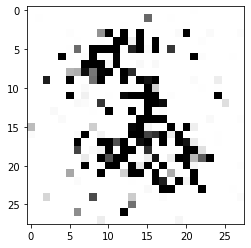

[0.00107226]
EPOCH: 7 / 40
Progress: 99.84 %     Sample time: 0.133s    _
Epoch time: 1:33s


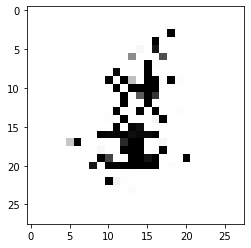

[9.18695531e-10]
EPOCH: 8 / 40
Progress: 99.84 %     Sample time: 0.025s    _
Epoch time: 2:47s


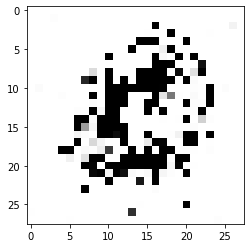

[5.40738828e-06]
EPOCH: 9 / 40
Progress: 99.84 %     Sample time: 0.025s    _
Epoch time: 0:34s


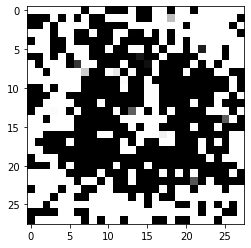

[1.45420864e-12]
EPOCH: 10 / 40
Progress: 99.84 %     Sample time: 0.108s    _
Epoch time: 0:58s


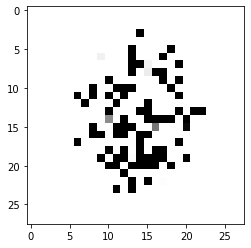

[2.22454279e-09]
EPOCH: 11 / 40
Progress: 2.38 %     Sample time: 0.116s    _

KeyboardInterrupt: 

In [58]:
epochs=40
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("\nEpoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    noise=np.random.uniform(-1,1,(1,100))
    gen=g.predict(noise)
    plt.imshow(gen.reshape(28,28), cmap='Greys')
    plt.show()
    print(d.predict(gen)[0])

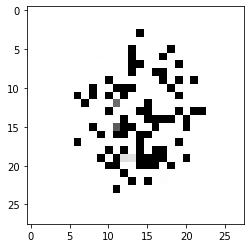

[[2.36262742e-07]]


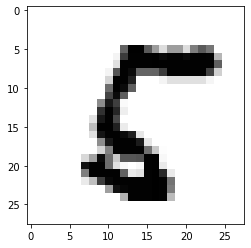

[[0.94760334]]


In [70]:
noise=np.random.uniform(-1,1,(1,100))
gen=g.predict(noise)
plt.imshow(gen.reshape(28,28), cmap='Greys')
plt.show()
print(d.predict(gen))
img=X_train[np.random.randint(low=0,high=X_train.shape[0],size=1)]
plt.imshow(img.reshape(28,28), cmap='Greys')
plt.show()
print(d.predict(img))